

#Key points


*   cVAE means conditional variational Auto encoder

*   We first encode the given data into 2 dimensional points, while being sure encoded points have Gaussian (normal) distribution.
* We condition the encoding with the label information
* In the second part, we decode the encoded information into a 28x28 digit

▶ We can generate various forms of desired numbers by inputting condition(label info) & various 2 dimensinal points into the decoder part of our model.


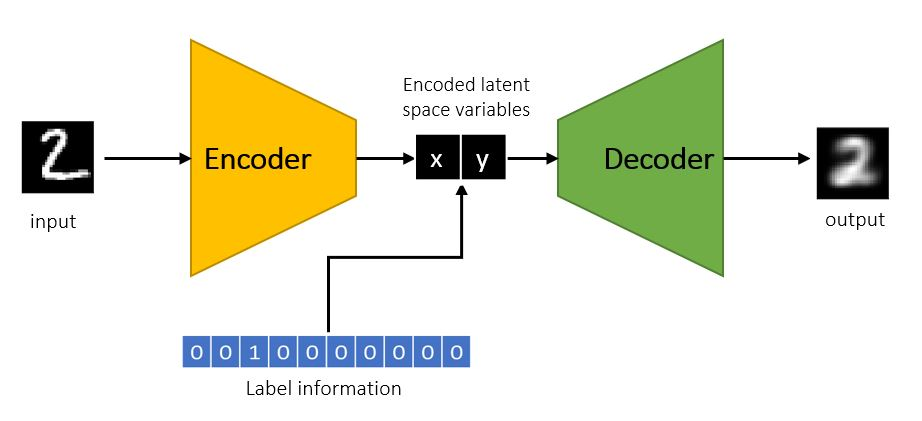




Let's first start by importing libraries;


### Import Libraries
* In this practice I used the library versions below, if your version cause a problem you can run the code below.

In [ ]:
!pip install keras==2.3.1
!pip install numpy==1.21.2
!pip install tensorflow-gpu==1.14

* We want to use the GPU for training:

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


* Finally we can import the libraries:

In [ ]:
#Here are some other libraries we will use
import warnings, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image 

#Keras is the main library we will use to model our network

from keras.layers import Input, Dense, Lambda, Reshape, Flatten, Conv2D, Concatenate, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras import backend as K

!pip install h5py pyyaml
warnings.filterwarnings('ignore')

### Load the MNIST dataset

In [4]:
## LOAD DATASET
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
img_rows, img_cols = X_train.shape[1:]

print("Data size is:",img_cols,"x", img_rows)


if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Normalize pixels of data in range [0,1] 
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Convert labels into one-hot coded arrays
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

Data size is: 28 x 28


#### Check the data in the dataset
You can check different datas by changing the number in the brackets in the bottom line.*italik metin*

Check the x-th train data in the dataset:


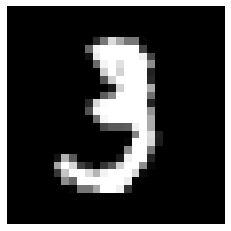

Label of the 10 th data is: 3
One-hot coded label of the 10 th data is: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [5]:
def check_data(x):
    print("Check the x-th train data in the dataset:")
    plt.imshow(X_train[x].reshape(28, 28), cmap = plt.cm.gray), plt.axis('off')
    plt.show()
    
    print("Label of the",x,"th data is:",Y_train[x])
    print("One-hot coded label of the",x,"th data is:",y_train[x])
    
check_data(10)

### Declare the training variables

In [ ]:
m = 500 # batch size
n_z = 2 # latent space size
n_classes = 10 #label number
activ = 'relu'
optim = RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

# n_x = X_train.shape[1]
# n_y = y_train.shape[1] #10
n_epoch = 15

* Below is the function we will use while sampling encodings into 2-dimensional points

In [7]:
def sample_z(args):
    mu, l_sigma = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, 2))
    return mu + K.exp(l_sigma / 2) * eps


### Model architecture
*   Now, we can build the encoder part of our model.
* We will use convolutional layers for out network.



In [ ]:
input_img = Input(shape=(28,28,1,))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2),padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x) #out: 7x7, 8
x = Conv2D(32,(7,7), activation='relu', padding='same')(x)
x = Conv2D(16,(7,7), activation='relu', padding='same')(x)
x = Conv2D(1,(7,7), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)
x_encoded = Dense(16, activation="relu")(x)

mu = Dense(2, activation='linear')(x_encoded)
l_sigma = Dense(2, activation='linear')(x_encoded)
cond_in = Input(shape=(n_classes,)) # we use labels as condition

#-------- Encoder sampler
z = Lambda(sample_z, output_shape=(2,))([mu, l_sigma])
z_cond = Concatenate(axis=-1)([z, cond_in])

* This is the decoder part of the model

In [9]:
def decoding(z):
    y = Dense(49, activation='relu')(z)
    y = Reshape((7,7,1))(y)
    y = Conv2D(32,(3,3), padding='same', activation='relu')(y)
    y = UpSampling2D((2,2))(y)
    y = Conv2D(64, (3,3), padding='same', activation='relu')(y)
    y = Conv2D(64, (3,3), padding='same', activation='relu')(y)
    y = UpSampling2D((2,2))(y)
    y = Conv2D(32, (3,3), padding='same', activation='relu')(y)
    y = Conv2D(16, (3,3), padding='same', activation='relu')(y)
    decoder_outputs = Conv2D(1, (3,3),activation='sigmoid', padding='same')(y)
    
    return decoder_outputs

z_in = Input(shape=(n_z,)) # 2-dimensional points as input

dec_input = Concatenate(axis=1)([z_in, cond_in])
dec_out = decoding(dec_input)

### Loss functions
The loss function consists of two parts, reconstruction loss and KL divergence loss.
* Reconstruction loss measures how much the generated image is similar to the input image
* KL (Kullback Leibler) divergence measures the error between the distribution we desire & the generated distribution.
* When we use Gaussian normal distribution, we use mean (mu) and variance (sigma) square to make sure generated distribution is normal distribution.

In [10]:
def vae_loss(y_true, y_pred):
    recon = K.mean(K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1))
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
 	return  0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)

def recon_loss(y_true, y_pred):
 	return K.mean(K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1))

### Compile the model
* You can check input & output layers of the each model by deleting # in front of __.summary() functions.

In [11]:
# Model construction:

encoder = Model([input_img], [mu, l_sigma, z], name='cVAE_encoder')
#encoder.summary()

decoder =  Model([z_in, cond_in], dec_out, name='cVAE_decoder')
#decoder.summary()

output = decoder([encoder([input_img])[2], cond_in])

cvae = Model([input_img, cond_in], output, name='cVAE')
cvae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
#cvae.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


* You can also see the model architecture shemes with the code below. *(Optional)*

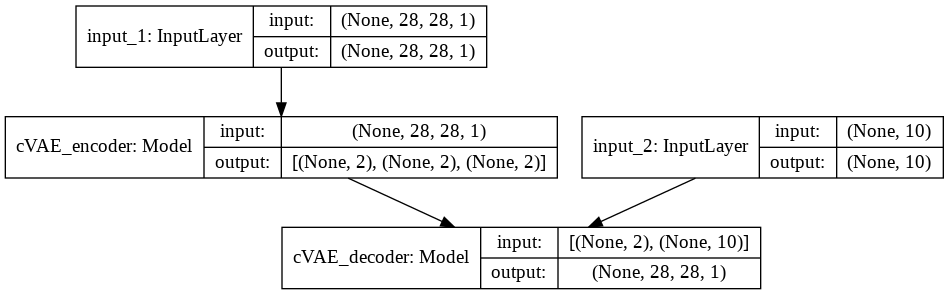

In [12]:
# Plot whole model achitecture
plot_model(cvae, to_file='cVAE_model_plot.png', show_shapes=True, show_layer_names=True)
Image('cVAE_model_plot.png', embed=True, retina=True)

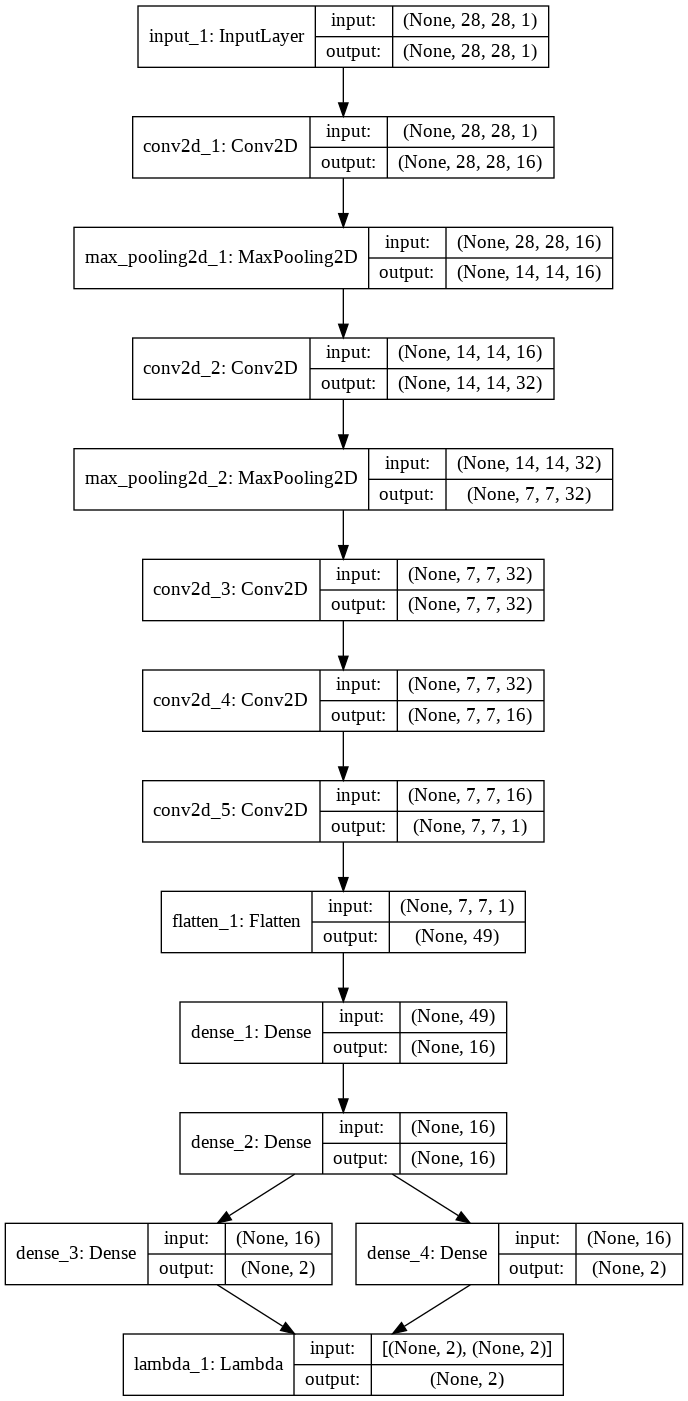

In [13]:
# Plot encoder achitecture
plot_model(encoder, to_file='cVAE_encoder_model_plot.png', show_shapes=True, show_layer_names=True)
Image('cVAE_encoder_model_plot.png', embed=True, retina=True)

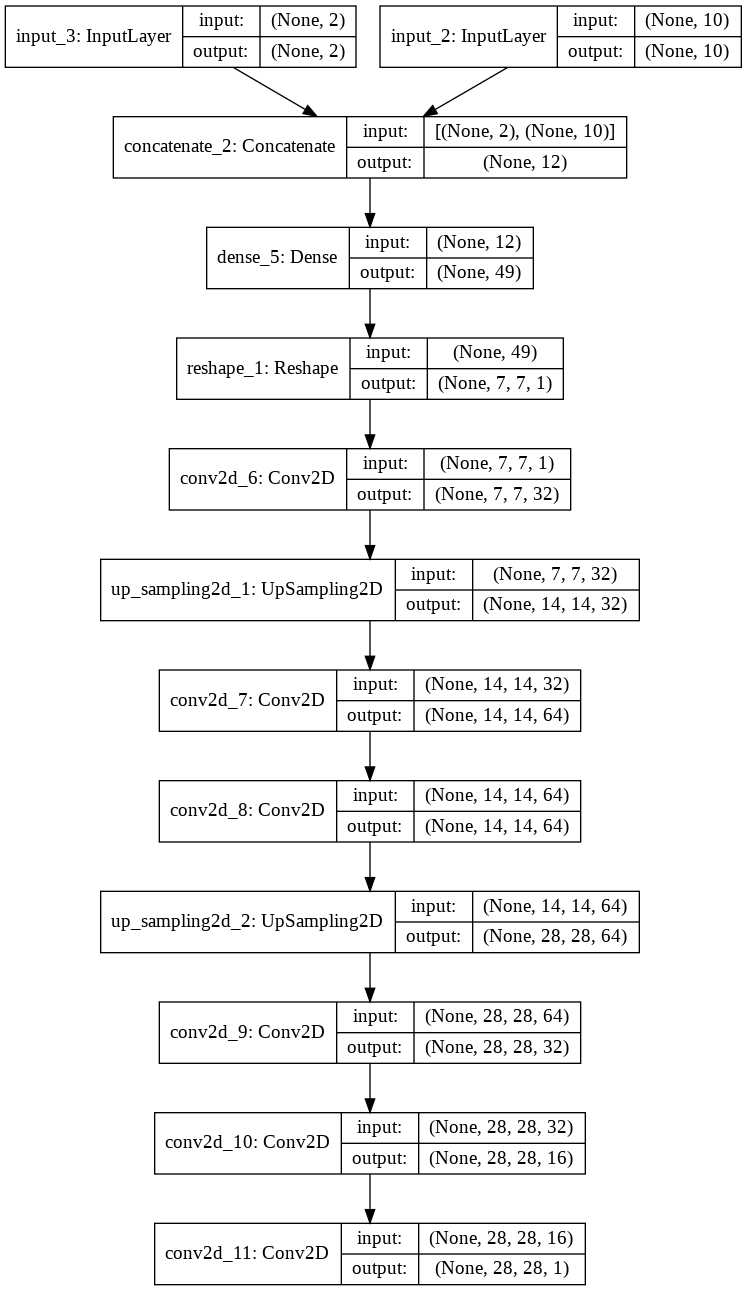

In [14]:
# Plot decoder achitecture
plot_model(decoder, to_file='cVAE_decoder_model_plot.png', show_shapes=True, show_layer_names=True)
Image('cVAE_decoder_model_plot.png', embed=True, retina=True)

### Train the model
* Now, we will train our model with the variables we declared at the top.
* I set the training for 30 epochs with 250 batchs.
* It takes around 2 minutes to our model get fully trained.

In [15]:
cvae_hist = cvae.fit([X_train, y_train], X_train, batch_size=m, verbose = 1, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience=5)])


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 19s 319us/step - loss: 0.3520 - KL_loss: 1.4476e-05 - recon_loss: 0.3520 - val_loss: 0.2621 - val_KL_loss: 3.1414e-06 - val_recon_loss: 0.2621
Epoch 2/15
60000/60000 [==============================] - 15s 246us/step - loss: 0.2521 - KL_loss: 4.7782e-06 - recon_loss: 0.2520 - val_loss: 0.2416 - val_KL_loss: 6.0062e-06 - val_recon_loss: 0.2416
Epoch 3/15
60000/60000 [==============================] - 15s 247us/step - loss: 0.2380 - KL_loss: 4.8559e-06 - recon_loss: 0.2380 - val_loss: 0.2334 - val_KL_loss: 3.2653e-06 - val_recon_loss: 0.2334
Epoch 4/15
60000/60000 [==============================] - 15s 247us/step - loss: 0.2295 - KL_loss: 2.2984e-06 - recon_loss: 0.2295 - val_loss: 0.2245 - val_KL_loss: 1.3380e-06 - val_recon_loss: 0.2244
Epoch 5/15
60000/60000 [==============================] - 15s 248us/step - loss: 0.2255 - KL_loss: 9.9541e-07 - recon_loss: 0.2255 - val_loss: 0.

###Results

#### Check the latent distribution of encoded data
* Below, you can see the distribution of encoded 2-dimensional points on the latent graph.
* As you can see, different colors show different numbers and they all distributed according to Gaussian distribution.

(10000, 2)


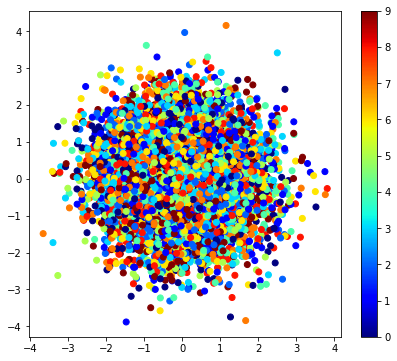

In [22]:
def construct_latent_plot():
    '''Following is map for distribution of the encoded values of the dataset, according to labels.'''
    z_train = encoder.predict([X_test], batch_size=m)
    pred_z = z_train[2]
    pred_z= np.asarray(pred_z)
    print(pred_z.shape)

    pred_z= pred_z.reshape(X_test.shape[0], n_z)
    plt.figure(figsize=(7, 6))
    plt.scatter(pred_z[:, 0], pred_z[:, 1], c=Y_test, cmap=plt.cm.jet)
    #print(encodings[2432,0:12])
    plt.colorbar()
    plt.show()

construct_latent_plot()

#### Comparing the output with the input data

*   You can compare the images with the below function



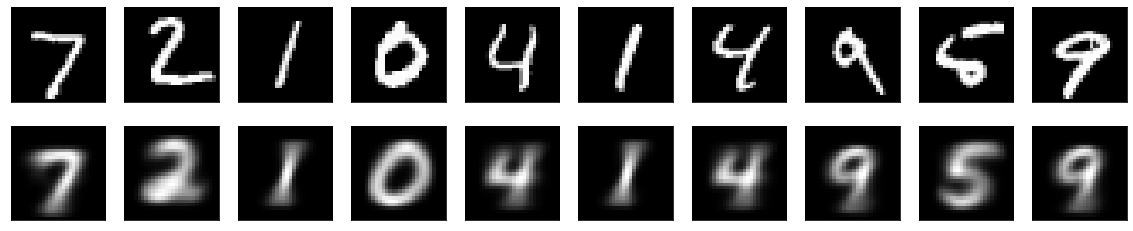

In [23]:
def compare_predicts(num_image_to_compare):
    decoded_imgs = cvae.predict([X_test, y_test], batch_size=m)
    
    X_testt = X_test.reshape(X_test.shape[0], 28, 28)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],28,28)
    
    plt.figure(figsize=(num_image_to_compare*2,4))
    for i in range(num_image_to_compare):
        
        ax = plt.subplot(2, num_image_to_compare , i+1)
        plt.imshow(X_testt[i], cmap = plt.cm.gray)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(2, num_image_to_compare, i+1+num_image_to_compare)
        plt.imshow(decoded_imgs[i], cmap = plt.cm.gray)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

compare_predicts(10)

#### Construct new images

* One of the advantages of conditional VAE is that you can generate the images you want by inputting the condition into the decoder of the model.
* For the latent coordinates, we can input (0,0) or else we can choose different coordinates since it's effect will be less than the condition (label)information.

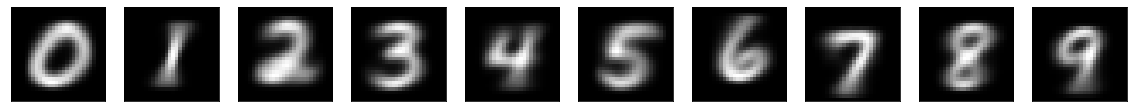

In [24]:
def construct_image():
    '''Following is for construction of digits 0 to 9 by inputting the label to decoder:'''    
    sample = np.eye(10,10)
    zero = np.zeros((1,2))
    decoded=np.zeros((10,28,28))
    for i in range(10):
       decoded[i] = decoder.predict([np.asarray(zero), np.asarray([sample[i]])],
                                    batch_size=m).reshape(28,28)
    plt.figure(figsize=(20, 2))
    
    for i in range(10):    
        ax = plt.subplot(1, 10 , i+1)
        plt.imshow(decoded[i], cmap = plt.cm.gray) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

construct_image()